# Variance of the weak-lensing convergence

**Author:** Pierre Fleury

## Theoretical considerations

A weakly-lensed GW sees its strain amplitude $h$ modified as $h^2=\mu\times\bar{h}^2$, where $\mu$ is the magnification and $\bar{h}$ is the unlensed amplitude. Equivalently, the luminosity distance to the GW source is modified as $D_{\rm L}=\bar{D}_{\rm L}/\sqrt{\mu}$.

If there are no multiple images, and treating the GW source as infinitesimal (point-like), then the magnification reads
$$
\mu = \frac{1}{(1-\kappa)^2 - |\gamma|^2 + \omega^2} ,
$$
where $\kappa$ is the convergence, $\gamma$ is the complex shear, and $\omega$ is the image rotation. In weak lensing, when all these quantities are small, we have as a rule of thumb $\omega \sim |\gamma|^2 \sim \kappa^2$. Hence,
$$
\mu = 1 + 2\kappa + \mathcal{O}(\kappa^2).
$$
This implies that the variance of the magnification reads
$$
\sigma_\mu^2
\equiv \langle\mu^2\rangle - \langle\mu\rangle^2
= 4 \langle\kappa^2\rangle + \mathcal{O}(\kappa^4),
$$
because at linear order $\langle\kappa\rangle=0$. Hence, if we work at second order in the weak-lensing quantities, the variance of the magnification is simply four times the variance of the linear-order convergence, $\sigma_\kappa^2$.


The purpose of this notebook is to evaluate $\sigma_\kappa$. We assume:
- weak lensing;
- flat sky;
- Limber's approximation.
However, we do not restrict to linear perturbation theory, in the sense that we use a fully non-linear matter power spectrum obtained with CAMB.

In that framework, the theoretical expression of variance of convergence is
$$
\sigma_\kappa^2
= \int_0^\infty \frac{\ell \mathrm{d}\ell}{2\pi} \; P_\kappa(\ell),
$$
with the flat-sky convergence power spectrum
$$
P_\kappa(\ell)
= \ell^2(\ell+1)^2 \int_0^{\chi_*} \mathrm{d}\chi
                                  \left( \frac{\chi_* - \chi}{\chi_* \chi^2} \right)^2
                                  \left( \frac{\chi}{\ell+1/2} \right)^4
                                  P_W \left(\eta_0-\chi, \frac{\ell+1/2}{\chi} \right) ,                               
$$
where $\chi_*$ is the comoving distance to the source, and $P_W$ is the Weyl power spectrum, which is readily computable in CAMB using Transfer_Weyl. The Weyl potential is defined as
$$
W \equiv \frac{1}{2} \Delta(\Psi+\Phi),
$$
where $\Psi$ and $\Phi$ are the Bardeen potentials. This implies that the resulting power spectrum will read
$$
P_W(k)
= k^4 P_\Phi(k)
= \left(\frac{3}{2}\Omega_{\rm m 0}H_0^2\right)^2(1+z)^2 P_\delta(k);
$$
and the presence of the $k^4$ factor has to be remembered. In terms of units,
$$
[P_W] = L^{-4} [P_\Phi] = L^{-1}.
$$

In [1]:
# Load packages, including CAMB
%matplotlib inline
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
# Use TeX
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
matplotlib.rcParams.update({'font.size': 18})

from scipy import constants, special, integrate
from scipy.optimize import curve_fit
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline as Spline

#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.3.2 installed at /Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/camb


## Contents<a class="anchor" id="contents"></a>
1. [Get Weyl power spectrum](#Weyl)
1. [Convergence power spectrum](#power_spectrum)
1. [Variance of the convergence](#variance)
1. [Simple fitting function](#fit)

## Generate Weyl power spectrum<a class="anchor" id="weyl"></a>
[Back to contents](#contents)

In [2]:
# CAMB parameters
H0 = 67.4
h = H0 / 100
Omega_m = 0.315
Omega_b = 0.05

pars = camb.CAMBparams()
pars.set_cosmology(H0=H0, ombh2=Omega_b*h**2, omch2=(Omega_m-Omega_b)*h**2)
pars.InitPower.set_params(ns=0.965)

class: <InitialPowerLaw>
 tensor_parameterization = tensor_param_rpivot
 ns = 0.965
 nrun = 0.0
 nrunrun = 0.0
 nt = -0.0
 ntrun = -0.0
 r = 0.0
 pivot_scalar = 0.05
 pivot_tensor = 0.05
 As = 2e-09
 At = 1.0
 

In [3]:
# Generate spectra up to small scales (this is the longest step)
zmax = 100
kmax = 5e2 #(inverse Mpc)
extrap_kmax = 1e10
Weyl_power_spectra = camb.get_matter_power_interpolator(pars, zmax=zmax, kmax=kmax, zs=None,
hubble_units=False, k_hunit=False, var1=model.Transfer_Weyl, var2=model.Transfer_Weyl, extrap_kmax=extrap_kmax)

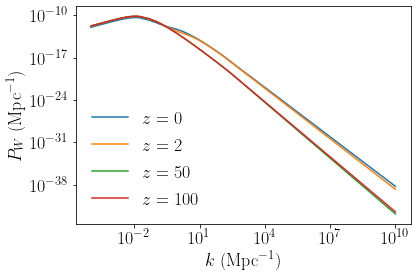

In [4]:
k = np.logspace(-4, 10, 100)

zplot = [0, 2, 50, 100]
for z in zplot:
    plt.loglog(k, Weyl_power_spectra.P(z,k))
#plt.xlim([1e-4,1e4])
plt.xlabel('$k$ (Mpc$^{-1}$)')
plt.ylabel('$P_W$ (Mpc$^{-1}$)')
plt.legend(['$z=%s$'%z for z in zplot], frameon=False);

<div class="alert alert-block alert-info">
When $k_{\rm max}$ is set to be larger than $10^3~\mathrm{Mpc}^{-1}$, the power spectrum gets really crazy on small scales at low $z$. Thus I opted with an extrapolation with a power law from $k_{\rm max} = 5\times 10^2~\mathrm{Mpc}^{-1}$ to $10^{10}~\mathrm{Mpc}^{-1}$. The latter huge value is because the integral over $\ell$ requires very small scales to be accounted for.
</div>

## Convergence power spectrum<a class="anchor" id="convergence"></a>
[Back to contents](#contents)

In [5]:
def get_cl_kappa(z, lmax, nl):
    """
    This function generates Cls for convergence and shear
    It takes as argument the redshift z of the source, and
    the maximum multipole lmax.
    nl is the number of values to be computed.
    """
    
    nz = 100 #number of elements for discrete integral along the los
    
    # Conformal distances and redshifts
    results= camb.get_background(pars)
    chi = results.conformal_time(0) - results.conformal_time(z)
    chis = np.linspace(0, chi, nz)
    zs = results.redshift_at_comoving_radial_distance(chis)
    
    # Array of delta_chi, and drop first and last points where things go singular
    dchis = (chis[2:]-chis[:-2])/2
    chis = chis[1:-1]
    zs = zs[1:-1]
    
    # Lensing kernel (spatially flat universe)
    kernel = ((chi-chis)/(chis**2*chi))**2
    
    # Integration over chi
    lmin = 1
    ls = np.logspace(np.log10(lmin), np.log10(lmax), nl)
    integral = np.zeros(ls.shape)
    w = np.ones(chis.shape) #this is just used to set to zero k values out of range of interpolation
    
    # Check that lmax is not too big
    if lmax > extrap_kmax * chis[-1]:
        print("""Warning: lmax is too large given the range of extrapolation given to CAMB
for the power spectrum. The results cannot be trusted.""")
    
    for i, l in enumerate(ls):
        k = (l + 0.5)/chis
        w[:] = 1
        w[k<1e-4] = 0
        w[k>=extrap_kmax] = 0
        integral[i] = np.dot(dchis, w * Weyl_power_spectra.P(zs, k, grid=False) * kernel / k**4)
        # The k**4 comes from the convention of CAMB for the Weyl potential, which is k**2 times
        # the actual gravitational potential.

    cl_kappa = integral * (ls * (ls+1))**2
    
    return ls, cl_kappa

In [6]:
lmax = 1e8
nl = 600
zplot = [1, 2, 50, 100] # source redshift
cl_kappa = []

for z in zplot:
    result = get_cl_kappa(z, lmax, nl)
    cl_kappa.append(result[1])
    
ls = result[0]

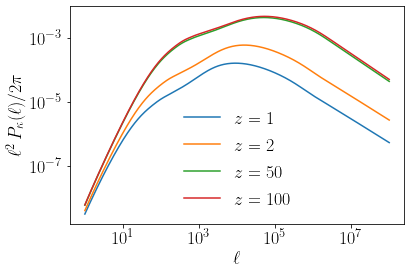

In [7]:
for i, z in enumerate(zplot):
    plt.loglog(ls, ls**2*cl_kappa[i]/(2*np.pi), label="$z = %s$"%z)
plt.ylabel('$\ell^2\,P_\kappa(\ell)/2\pi$')
plt.xlabel('$\ell$')
#plt.xlim([1e2,1e6])
#plt.ylim([1e-7,4e-5])
plt.legend(frameon=False);

# Variance of the convergence<a class="anchor" id="variance"></a>
[Back to contents](#contents)

In [8]:
def variance_convergence(z, lmax=1e7):
    """
    This function computes the variance of the weak-lensing convergence
    for a source at a redshift z. Integration is performed until lmax.
    """
    
    # Compute the power spectrum
    nl = 1000
    ls, cl_kappa = get_cl_kappa(z, lmax, nl)
    
    # Integration over l. Attention, the ls are homogeneously distributed in
    # log space, so the natural intregration variable is log10(l) rather than l
    logls = np.log10(ls)
    dlogls = (logls[2:] - logls[:-2]) / 2
    integrand = np.log(10) * ls**2 * cl_kappa / (2 * np.pi)
    integrand = integrand[1:-1]
    
    sigma2 = np.dot(dlogls, integrand)
    
    return sigma2

Check the convergence with $\ell_{\rm max}$.

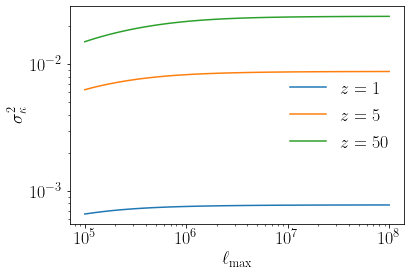

In [9]:
lmaxs = np.logspace(5, 8, 100)

for z in [1, 5, 50]:
    sigma2 = [variance_convergence(z, lmax) for lmax in lmaxs]
    plt.loglog(lmaxs, sigma2, label=r'$z={}$'+str(z))
    
#plt.ylim([0, 3e-3])
plt.ylabel(r'$\sigma_\kappa^2$')
plt.xlabel(r'$\ell_{\rm max}$')
plt.legend(frameon=False)
plt.show()

<div class="alert alert-block alert-info">
<b>Conclusion:</b> It seems safe to set $\ell_{\rm max}=10^7$.
</div>

In [10]:
def variance_naive(z):
    """
    This is the "naive" prescription used by the JLA, which cites Jönsson et al. (2010).
    The result is that the standard deviation of the *distance modulus* is 0.055z.
    """
    
    sigma_mu = 0.055 * z
    sigma_kappa = np.log(10)/5 * sigma_mu
    sigma2 = sigma_kappa**2
    
    return sigma2

Compare our result with the naive prescription

In [11]:
lmax = 1e7
zs = np.logspace(-1, 2, 100)
sigma = [np.sqrt(variance_convergence(z, lmax)) for z in zs]
sigma = np.array(sigma)
sigma_naive = np.sqrt(variance_naive(zs))

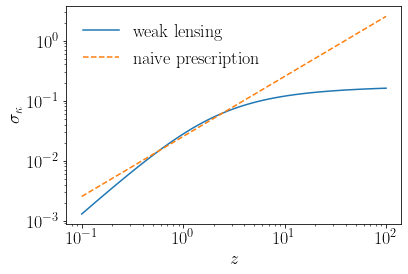

In [12]:
plt.loglog(zs, sigma, label='weak lensing')
plt.loglog(zs, sigma_naive, '--', label='naive prescription')
plt.ylabel(r'$\sigma_{\kappa}$')
plt.xlabel(r'$z$')
plt.legend(frameon=False)
plt.show()

Focus on low redshifts

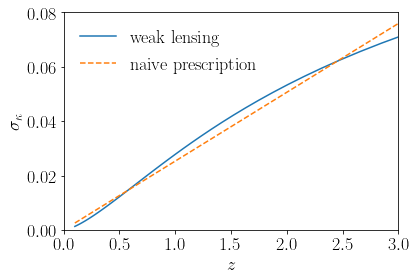

In [13]:
plt.plot(zs, sigma, label='weak lensing')
plt.plot(zs, sigma_naive, '--', label='naive prescription')
plt.xlim([0, 3])
plt.ylim([0, 0.08])
plt.ylabel(r'$\sigma_{\kappa}$')
plt.xlabel(r'$z$')
plt.legend(frameon=False)
plt.show()

<div class="alert alert-block alert-info">
As expected, the naive prescription is rather good at low $z$, but it highly overestimates $\langle\kappa^2\rangle$ at large redshifts. The standard devation of the luminosity distance never exceeds $20\%$.
</div>

In [14]:
print("""At z = 100, the relative error due to lensing reaches:
sigma_lens = {}""".format(np.sqrt(variance_convergence(100))))

At z = 100, the relative error due to lensing reaches:
sigma_lens = 0.16114133935561184


## Simple fitting function<a class="anchor" id="fit"></a>
[Back to contents](#contents)

[0.11605285 1.25725535 1.46334517 0.26809483]


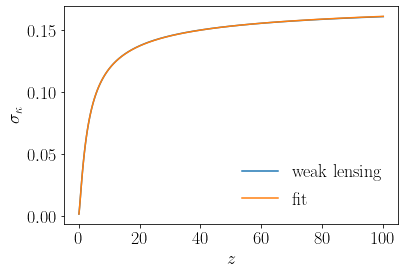

In [15]:
def sigma_fit(z, a, b, c, d):
    #sigma = a * np.arctan(b * np.log(1 + c * z**d))
    sigma = a * np.arctan((1 + b * z**c)**d - 1)
    
    return sigma

popt, pcov = curve_fit(sigma_fit, zs, sigma)
print(popt)

plt.plot(zs, sigma, label='weak lensing')
plt.plot(zs, sigma_fit(zs, *popt), label='fit')
plt.ylabel(r'$\sigma_{\kappa}$')
plt.xlabel(r'$z$')
plt.legend(frameon=False)
plt.show()

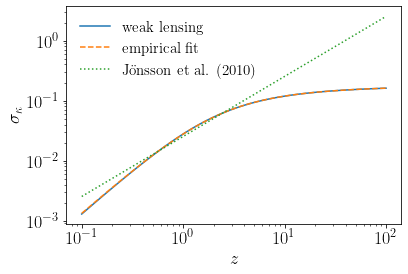

In [16]:
# compare weak lensing with naïve prescription
plt.loglog(zs, sigma, label='weak lensing')
plt.loglog(zs, sigma_fit(zs, *popt), '--', label='empirical fit')
plt.loglog(zs, sigma_naive, ':', label='Jönsson et al. (2010)')
#plt.xlim([0, 3])
#plt.ylim([0, 0.2])
plt.ylabel(r'$\sigma_{\kappa}$')
plt.xlabel(r'$z$')
plt.legend(frameon=False, loc='best', fontsize='small')
#plt.savefig("sigma_kappa.pdf", format='pdf', transparent=True, bbox_inches='tight')
plt.show()

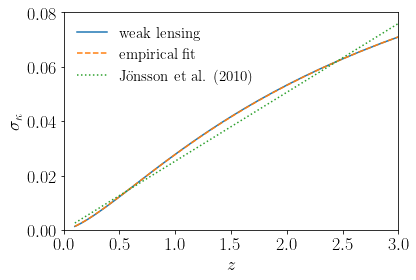

In [17]:
# focus on low redshifts
plt.plot(zs, sigma, label='weak lensing')
plt.plot(zs, sigma_fit(zs, *popt), '--', label='empirical fit')
plt.plot(zs, sigma_naive, ':', label='Jönsson et al. (2010)')
plt.xlim([0, 3])
plt.ylim([0, 0.08])
plt.ylabel(r'$\sigma_{\kappa}$')
plt.xlabel(r'$z$')
plt.legend(frameon=False, fontsize='small')
#plt.savefig("sigma_kappa_low_z.pdf", format='pdf', transparent=True, bbox_inches='tight')
plt.show()

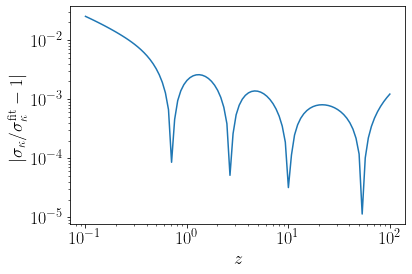

In [18]:
# relative error of the fit
plt.loglog(zs, abs(sigma/sigma_fit(zs, *popt) - 1))
plt.ylabel(r'$|\sigma_\kappa/\sigma^{\rm fit}_\kappa - 1|$')
plt.xlabel(r'$z$')
plt.show()

<div class="alert alert-block alert-info">
The fitting function is accurate at subpercent level.
</div>